<a href="https://colab.research.google.com/github/MekhzZ/opencv_bootcamp_exercise/blob/main/07_Image_Alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Homography is a mathematical concept that describes the relationship between two images of the same scene taken from different viewpoints. It can be represented as a transformation that relates points in one image to points in another, typically expressed as a 3x3 matrix.
 - Homography is essential in applications such as image stitching, augmented reality, and 3D reconstruction.

- It can be estimated using algorithms like the Direct Linear Transform (DLT).

- Every homography can be viewed as a composition of a finite number of perspective transformations.


## Align an image to a template.
![alt text](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_image-alignment-using-opencv.jpg "Image Alignment")

[Homography in computer vision explained](https://youtu.be/MlaIWymLCD8)



A **Homography** transforms a square to arbitrary quad.

![alt text](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_motion-models.jpg "Motion Models")

- Images of two planes are related by homography for which we need 4 corresponding points.

In [1]:
# importing libraries

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

In [2]:
# downloading Assets

def download_and_unzip(url, save_path):
  print('downloading..', end ='')
  urlretrieve(url, save_path)

  try:
    with ZipFile(save_path) as z:
      z.extractall(os.path.split(save_path)[0])

    print('Done')

  except Exception as e:
    print('error')
    print(e)

In [3]:
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

downloading..Done


## reading images

In [8]:
form_img = cv2.imread('/content/form.jpg', cv2.IMREAD_COLOR)
form_img_rgb = cv2.cvtColor(form_img, cv2.COLOR_BGR2RGB)

scanned_img = cv2.imread('/content/scanned-form.jpg', cv2.IMREAD_COLOR)
scanned_img_rgb = cv2.cvtColor(scanned_img, cv2.COLOR_BGR2RGB)

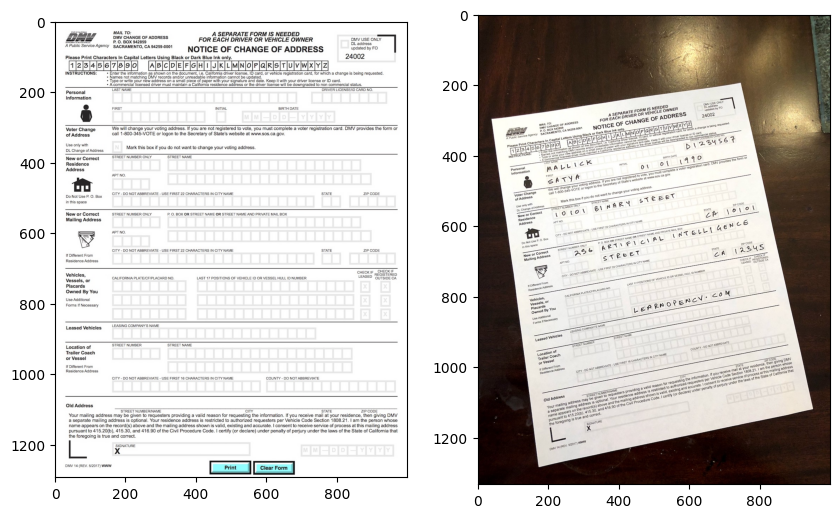

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(121); plt.imshow(form_img_rgb)
plt.subplot(122); plt.imshow(scanned_img_rgb)



##  Step 1 : Finding keypoints in both Images

In [11]:
form_img_gray = cv2.cvtColor(form_img, cv2.COLOR_BGR2GRAY)
scanned_img_gray = cv2.cvtColor(scanned_img, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create(500) # max num of features = 500

# ORB
keypoints1, descriptions1 = orb.detectAndCompute(form_img_gray, None)
keypoints2, descriptions2 = orb.detectAndCompute(scanned_img_gray, None)

In [18]:
form_img_display = cv2.drawKeypoints(form_img, keypoints1,outImage=np.array([]),color = (255,0,0), flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
scanned_img_display = cv2.drawKeypoints(scanned_img, keypoints2,outImage=np.array([]),color = (255,0,0), flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


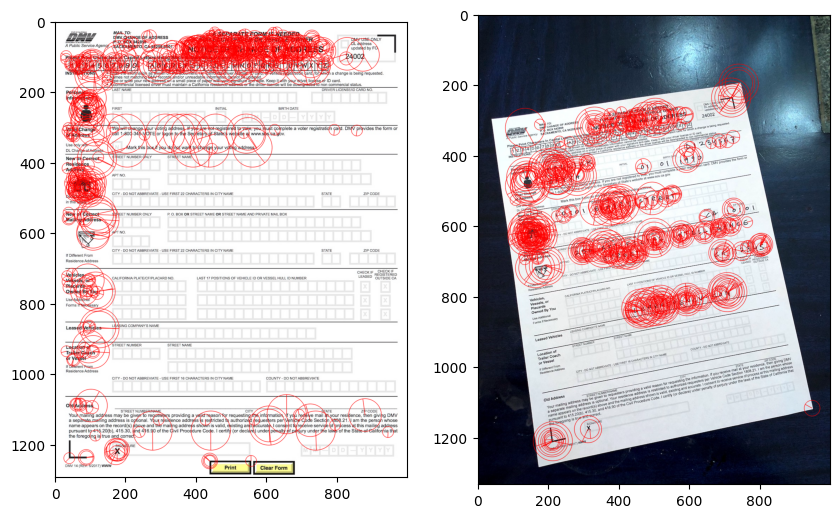

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(121); plt.imshow(form_img_display)
plt.subplot(122); plt.imshow(scanned_img_display)

Explore more about ORB(Oriented FAST and Rotated BRIEF) in below doc link

ORB, an algorithm that combines the two algorithms FAST for keypoints and BRIEF for Descriptors

[ORB docs](https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html)

## Step 2 : Matching Keypoints

In [20]:
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# tuples into list cause tuples are immutable
matches = list(matcher.match(descriptions1, descriptions2, None))

# sorts based on distance asc
matches.sort(key=lambda x: x.distance, reverse=False)

# selects the top 10%
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

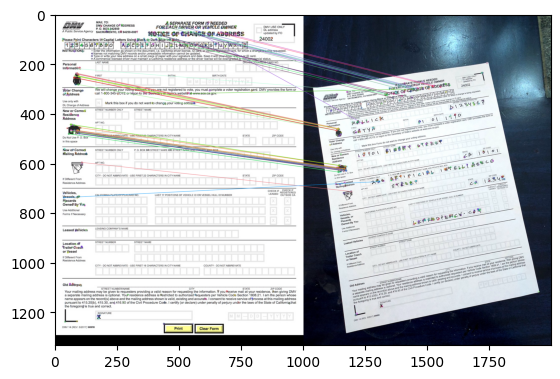

In [21]:
im_matches = cv2.drawMatches(form_img, keypoints1, scanned_img, keypoints2, matches, None)

plt.imshow(im_matches)
plt.show()

## Step 3 : Homography

In [30]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt


h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

- cv2.findHomography(): This OpenCV function is the core of this process, used to estimate the homography matrix (h) that transforms points2 (scanned image keypoints) to points1 (template image keypoints).
- cv2.RANSAC: This stands for "Random Sample Consensus" and is an algorithm used within findHomography to handle outliers (incorrect matches) robustly, ensuring a more accurate homography estimation.
- mask: This output indicates the inliers (correctly matched points) used in the homography calculation.

## Step 4 : wrapping Image

In [31]:
ht,w,c = form_img.shape
wrapped_img = cv2.warpPerspective(scanned_img, h, (w,ht))

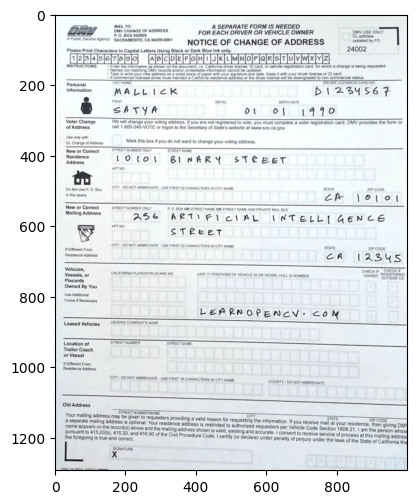

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(122); plt.imshow(wrapped_img)

the scanned Image we have is successfully converted to the template image

Text(0.5, 1.0, 'wrapped Image')

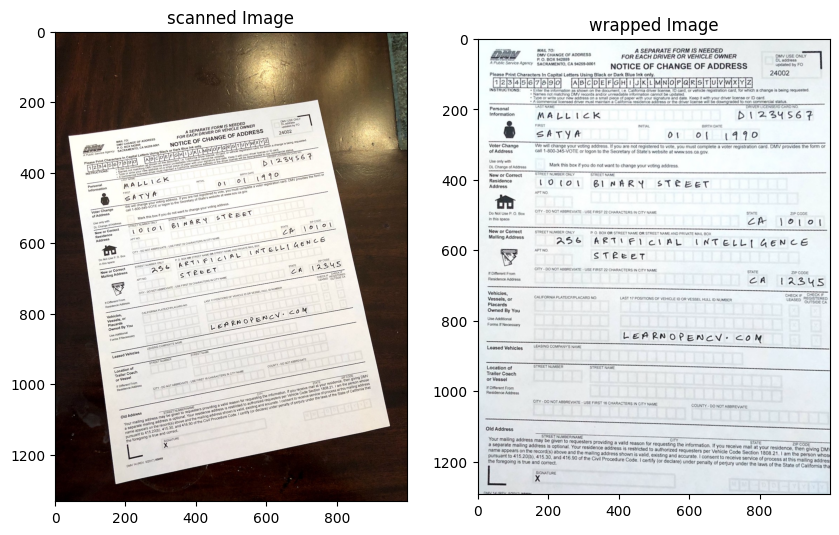

In [39]:
plt.figure(figsize=(10,10))
plt.subplot(121); plt.imshow(scanned_img_rgb) ; plt.title('scanned Image')
plt.subplot(122); plt.imshow(wrapped_img); plt.title('wrapped Image')